In [1]:
from MA import run_ma
from itertools import product
from target_transformation import TargetTransformation
from dc_transformation import DCTransformer
import numpy as np
import matplotlib.pyplot as plt
import json
import math
plt.style.use('seaborn')

In [2]:
font = {'family': 'serif',
        'weight': 'normal',
        'size': 20,
}

In [3]:
with open('m4_daily_finance_2.json') as file:
    datasets = json.load(file)

datasets = {
    k: {
        'raw': v,
        'length': len(v)
    } for k, v in datasets.items()
}

print(list(datasets.keys()))

['2040', '2440']


In [4]:
use = '2040'

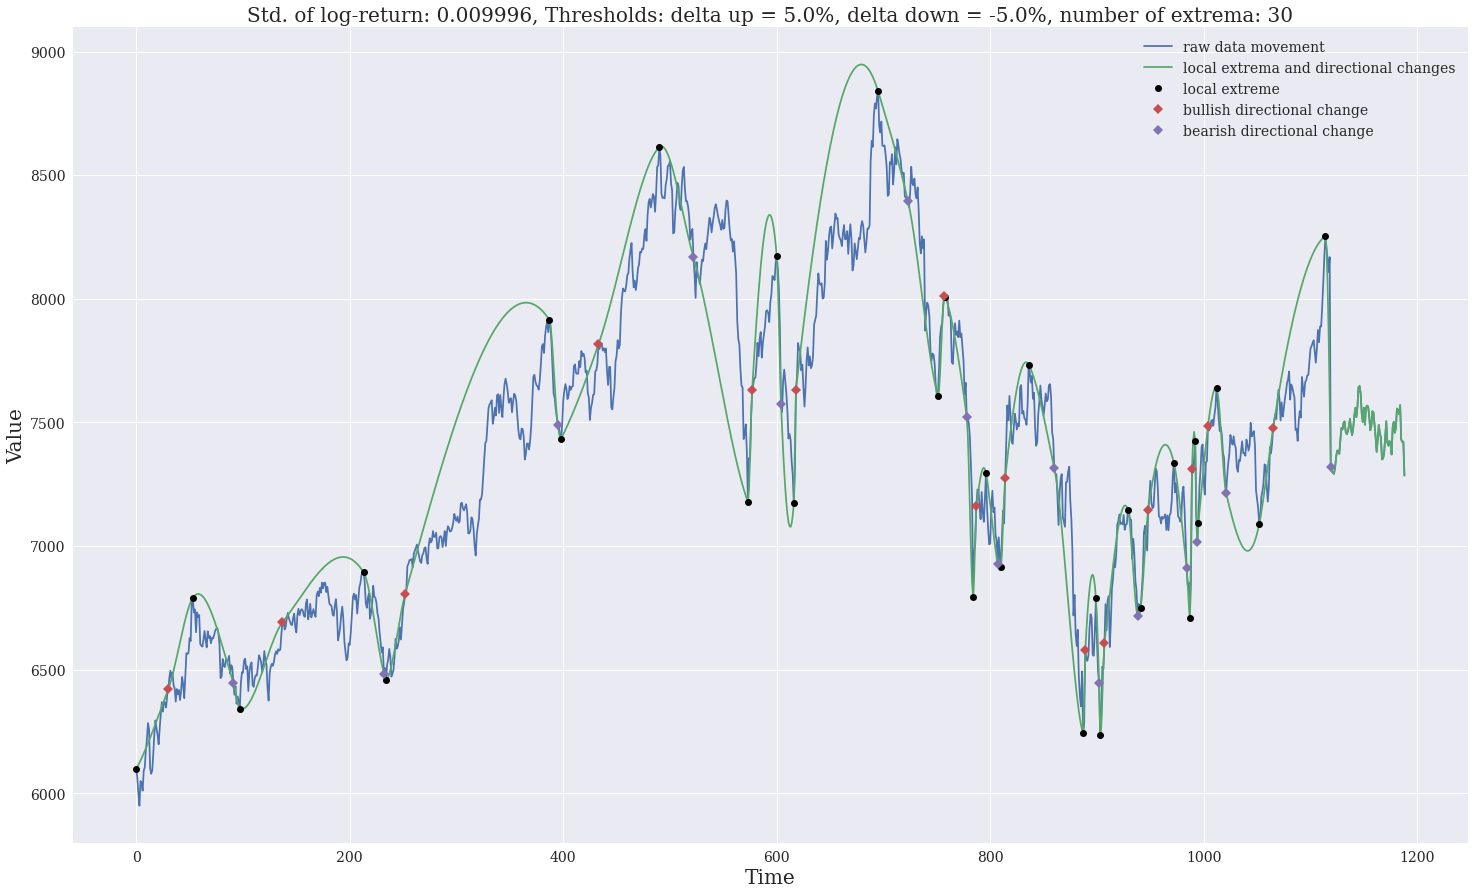

In [9]:
t1 = DCTransformer()
t1.transform(datasets[use]['raw'], threshold=(0.05, -0.05), kind='akima')
t1.make_plot(marks=True)

tra = np.diff(np.log(t1.tdata1))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


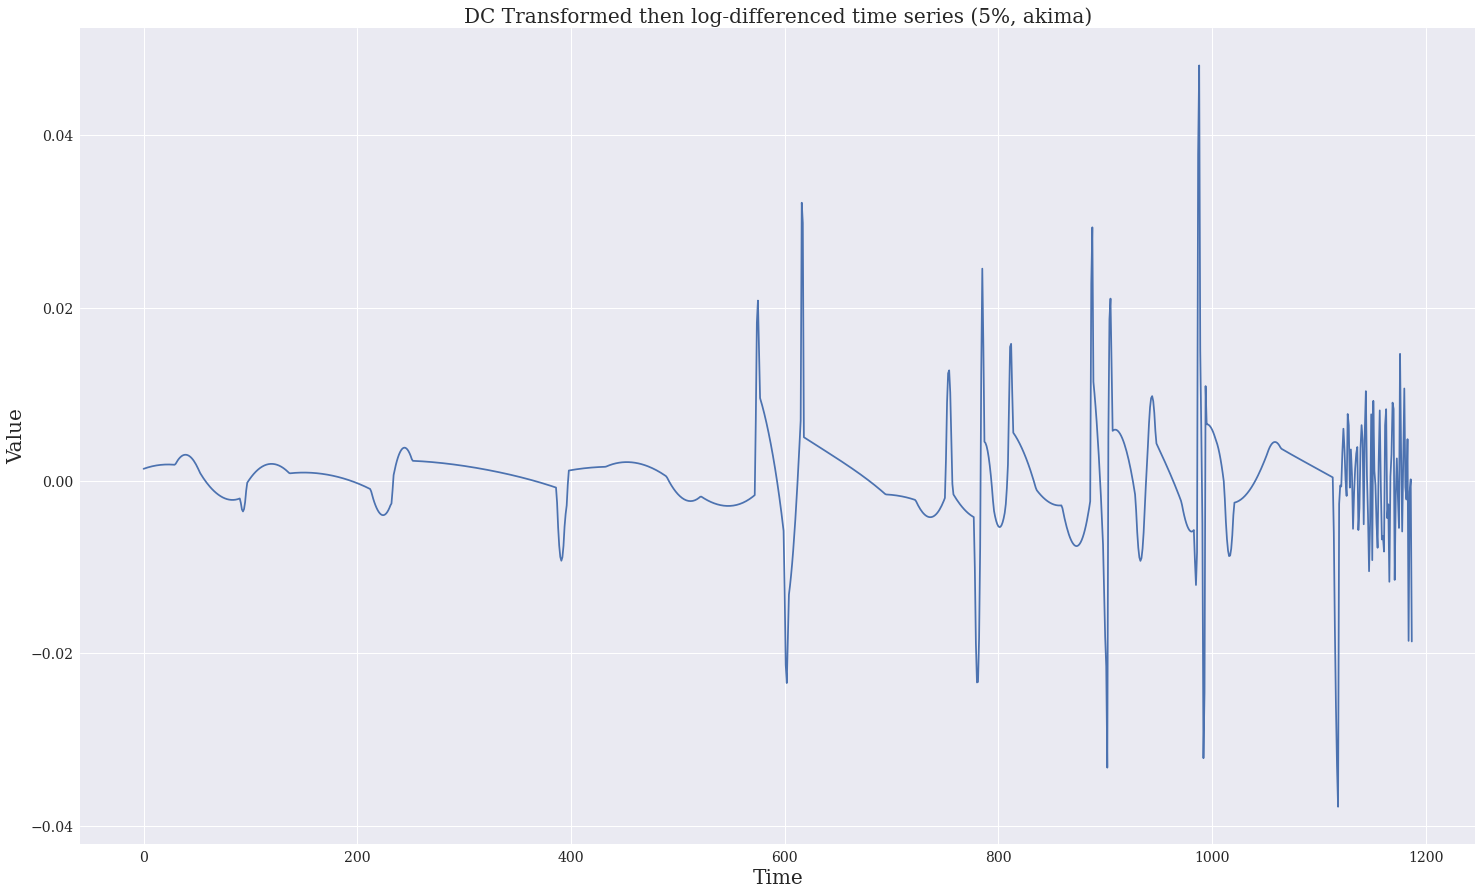

In [13]:
plt.figure(figsize=(25, 15))
plt.plot(tra)
plt.title(f'DC Transformed then log-differenced time series (5%, akima)', fontdict=font)
plt.legend(prop={'size': 14, 'family': 'serif'})
plt.xticks(fontsize=14, fontname='serif')
plt.yticks(fontsize=14, fontname='serif')
plt.xlabel('Time', fontdict=font)
plt.ylabel('Value', fontdict=font)
plt.show()

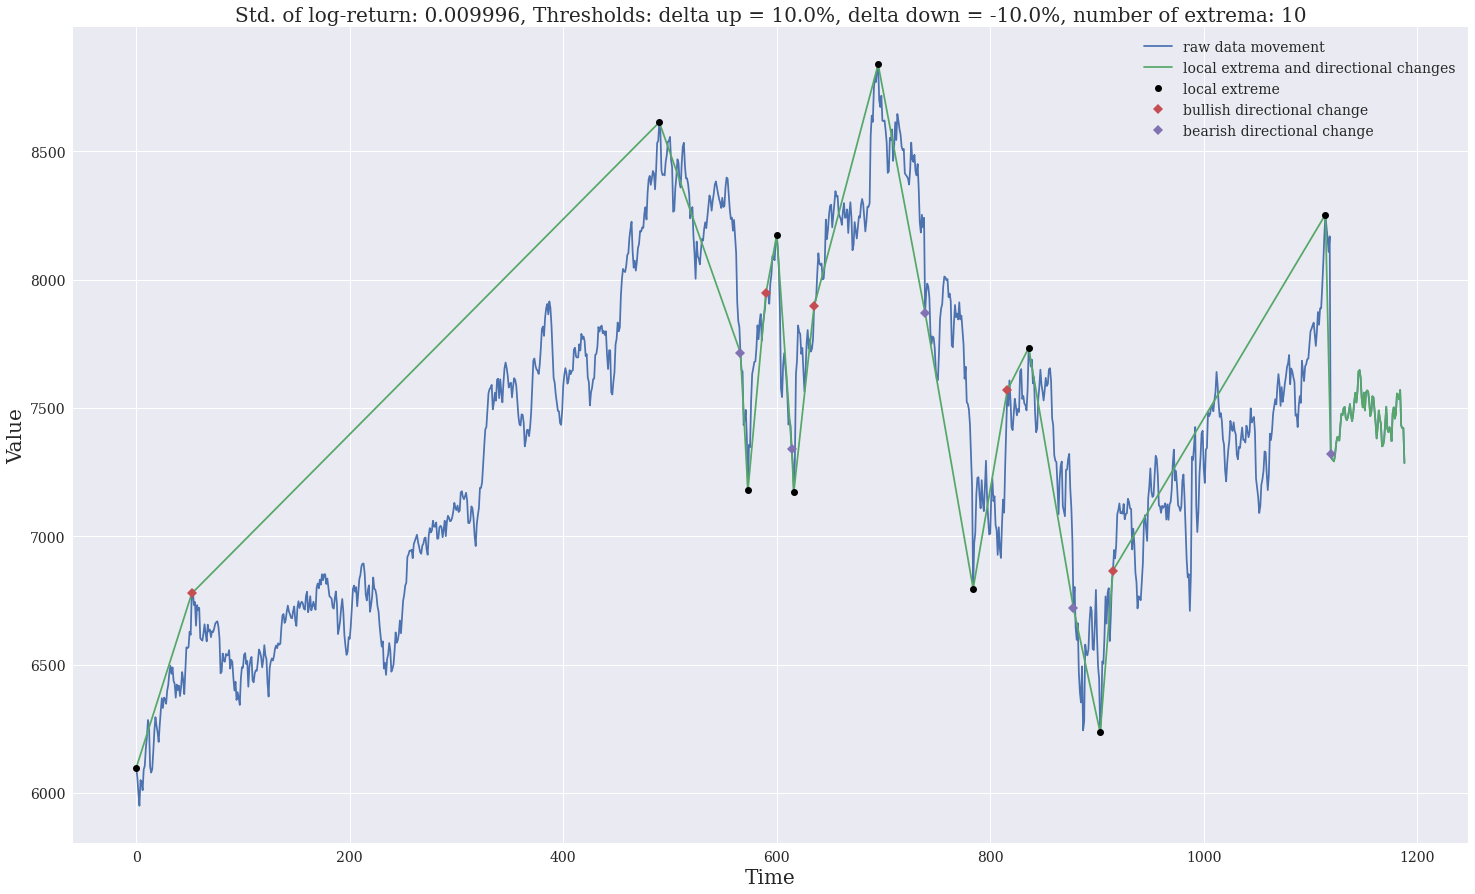

In [7]:
t2 = DCTransformer()
t2.transform(datasets[use]['raw'], threshold=(0.1, -0.1), kind='linear')
t2.make_plot(marks=True)

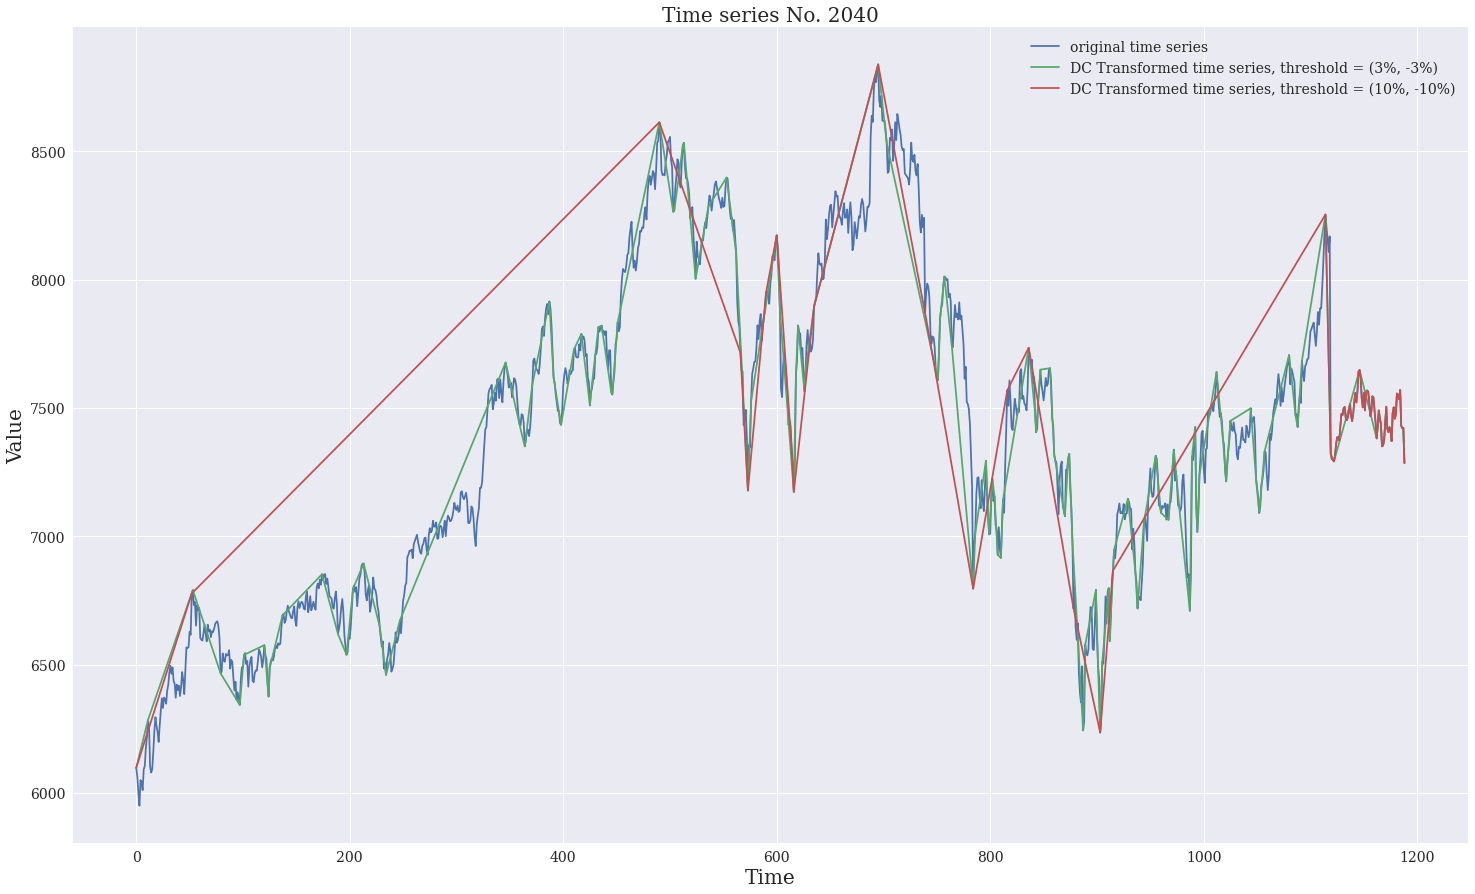

In [19]:
plt.figure(figsize=(25, 15))
plt.plot(datasets[use]['raw'], label='original time series')
plt.plot(t1.tdata1, label=f'DC Transformed time series, threshold = (3%, -3%)')
plt.plot(t2.tdata1, label=f'DC Transformed time series, threshold = (10%, -10%)')
plt.title(f'Time series No. {use}', fontdict=font)
plt.legend(prop={'size': 14, 'family': 'serif'})
plt.xticks(fontsize=14, fontname='serif')
plt.yticks(fontsize=14, fontname='serif')
plt.xlabel('Time', fontdict=font)
plt.ylabel('Value', fontdict=font)
plt.show()

In [ ]:

with open('config.json') as file:
    config = json.load(file)

In [74]:
def SAPE(y, y_hat):
    if type(y) == float or type(y) == int:
        return np.abs(y_hat-y)/np.mean((np.abs(y_hat), np.abs(y)))

    zero = [0 for _ in range(len(y))]
    return math.dist(y, y_hat)/np.mean(math.dist(y, zero), math.dist(y_hat, zero))

t_config = config['transformation config']
xthresholds = [round(x, 3) for x in np.arange(*t_config['xthresholds'])]
interp_kind = t_config['interp kind']
use_states = t_config['use states']
target_transform = 'log-return' # t_config['target transformation']

# transformation policies
t_policies = list(product(xthresholds, xthresholds, interp_kind, use_states))

models_params = {
    'MA': {
        'q': [5]
    }
}

raw_MA_policies = [
    {
        'q': h[0]
    } for h in product(*models_params['MA'].values())
]

tran_MA_policies = [
    {
        'thres up': h[0][0],
        'thres down': h[0][1],
        'interp kind': h[0][2],
        'use states': h[0][3],
        'q': h[1]
    } for h in product(t_policies, *models_params['MA'].values())
]

all_policies = {
    'MA': {
        'raw': raw_MA_policies,
        'tran': tran_MA_policies
    }
}

args = {
    'model': 'MA',
    'datasets': datasets,
    'ttype': target_transform,
    'v_size': config['modelling config']['validation size'],
    'retrain_window': config['modelling config']['retrain window'],
    't_size': config['modelling config']['test size'],
    'horizon': config['modelling config']['forecast horizon'],
    'gap': config['modelling config']['gap'],
    'score': SAPE,
    'policies': all_policies['MA'],
    'n_workers': config['execution config']['n of workers']
}
del args['model']

raw_info, tran_info = run_ma(**args)

Running MA: 100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


In [75]:
use = '2040'

In [76]:
test_size = config['modelling config']['test size']
test_set_count = int(len(datasets[use]['raw']) * test_size)
test_set = datasets[use]['raw'][-(test_set_count):]

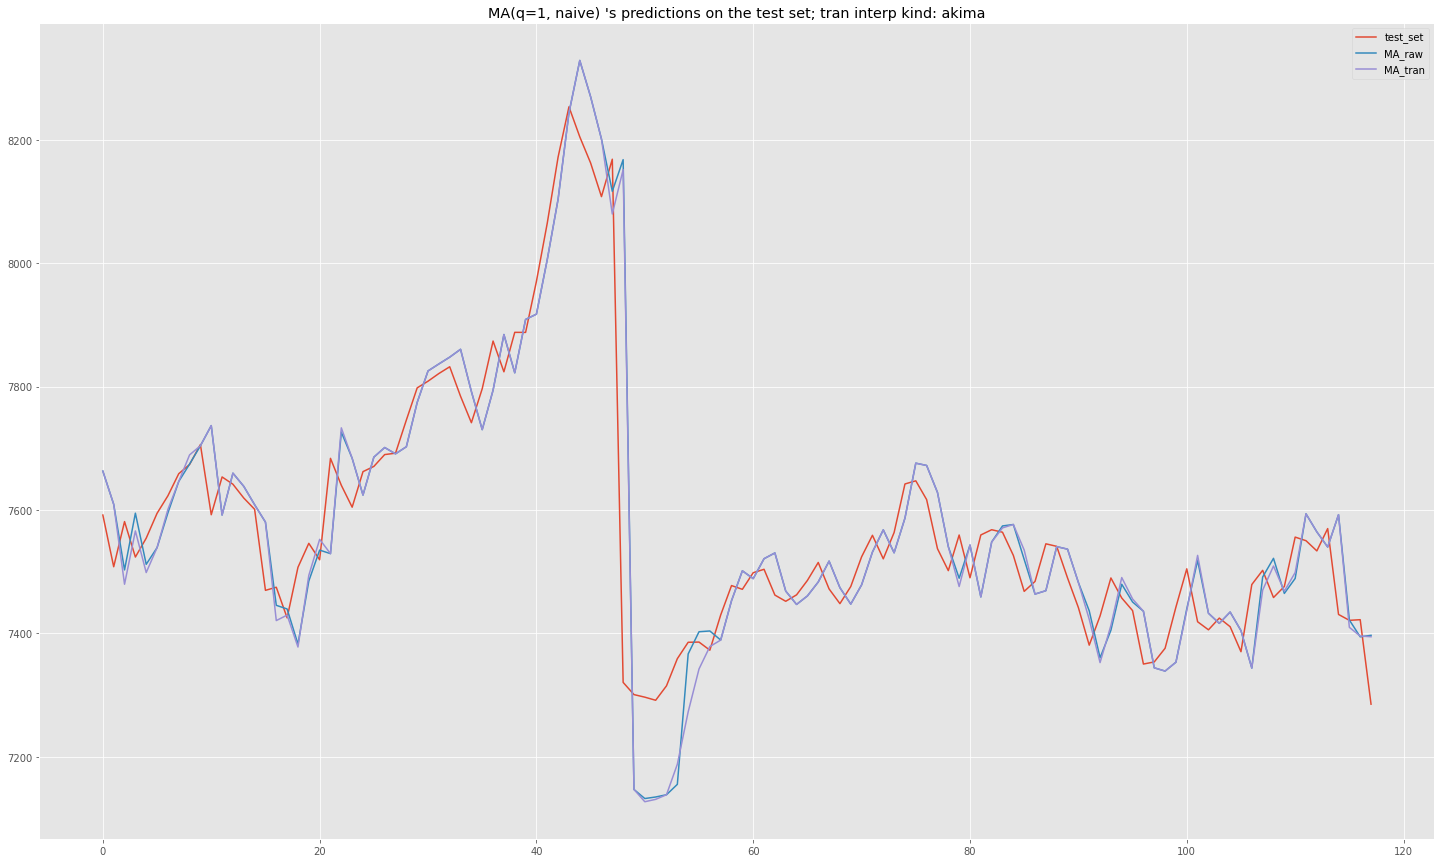

In [77]:
model = 'MA'
inter_kind = tran_info[use]['best model']['interp kind']

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(raw_info[use]['y hats'], label=f'{model}_raw')
plt.plot(tran_info[use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}(q=1, naive) \'s predictions on the test set; tran interp kind: {inter_kind}')
plt.legend()
plt.show()

In [78]:
use = '2440'

In [79]:
test_size = config['modelling config']['test size']
test_set_count = int(len(datasets[use]['raw']) * test_size)
test_set = datasets[use]['raw'][-(test_set_count):]

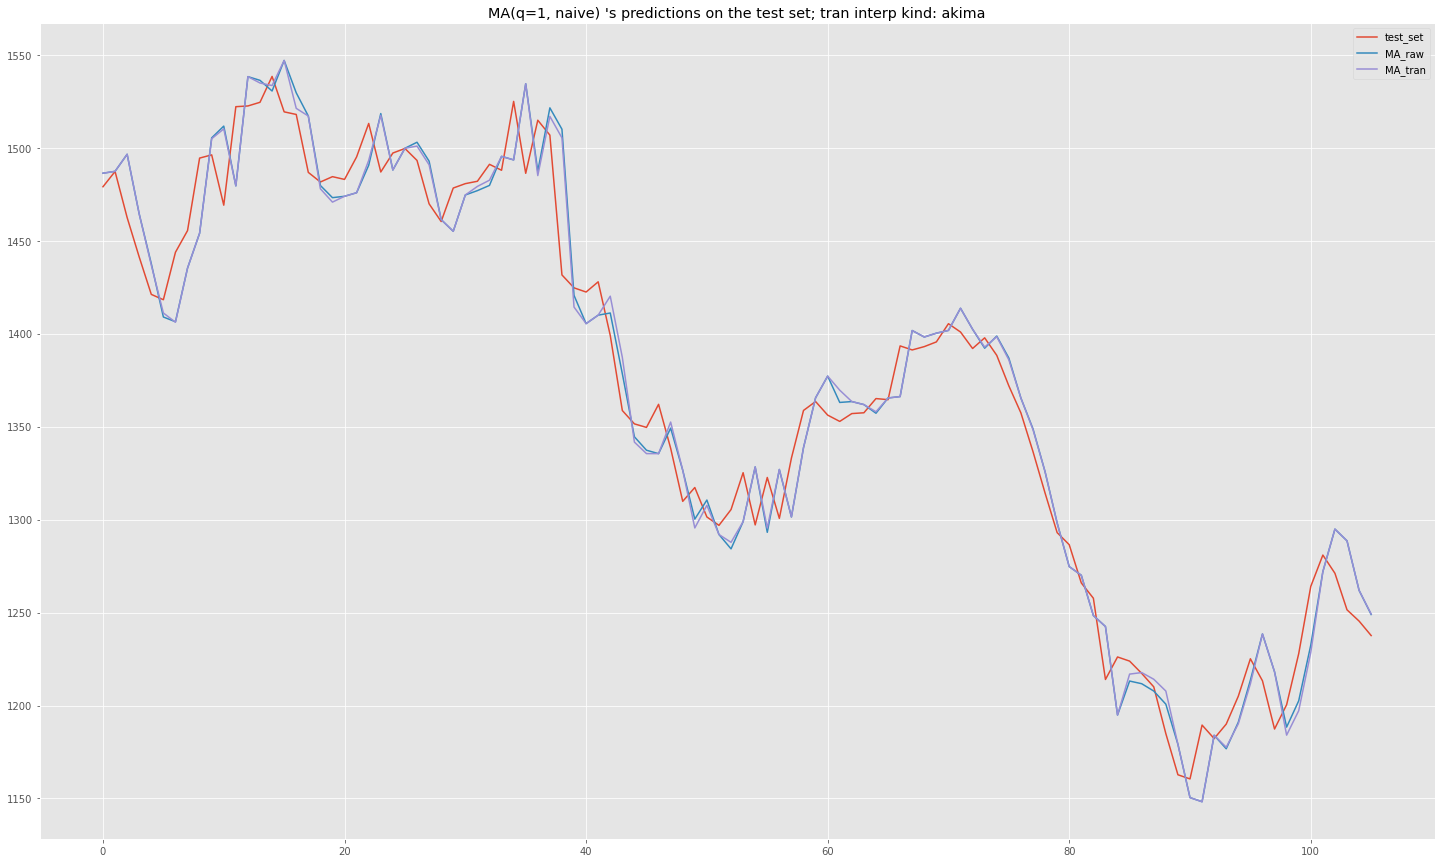

In [80]:
model = 'MA'
inter_kind = tran_info[use]['best model']['interp kind']

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(raw_info[use]['y hats'], label=f'{model}_raw')
plt.plot(tran_info[use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}(q=1, naive) \'s predictions on the test set; tran interp kind: {inter_kind}')
plt.legend()
plt.show()